# 1. Setup
1.1 Install Dependencies

In [1]:
!pip install jupyterlab-night

     ---------------------------------------- 0.0/162.4 kB ? eta -:--:--
     --------------------------------- ---- 143.4/162.4 kB 4.3 MB/s eta 0:00:01
     ----------------------------------- -- 153.6/162.4 kB 4.6 MB/s eta 0:00:01
     -------------------------------------- 162.4/162.4 kB 1.6 MB/s eta 0:00:00


In [1]:
!pip install tensorflow==2.12.0 opencv-python matplotlib

  Using cached tensorflow-2.12.0-cp311-cp311-win_amd64.whl (1.9 kB)
  Using cached tensorflow_intel-2.12.0-cp311-cp311-win_amd64.whl (272.9 MB)
  Using cached jax-0.4.14-py3-none-any.whl
  Using cached numpy-1.23.5-cp311-cp311-win_amd64.whl (14.6 MB)
  Using cached tensorboard-2.12.3-py3-none-any.whl (5.6 MB)
  Using cached tensorflow_estimator-2.12.0-py2.py3-none-any.whl (440 kB)
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Obtaining dependency information for ml-dtypes>=0.2.0 from https://files.pythonhosted.org/packages/08/89/c727fde1a3d12586e0b8c01abf53754707d76beaa9987640e70807d4545f/ml_dtypes-0.2.0-cp311-cp311-win_amd64.whl.metadata
  Using cached ml_dtypes-0.2.0-cp311-cp311-win_amd64.whl.metadata (20 kB)
Using cached ml_dtypes-0.2.0-cp311-cp311-win_amd64.whl (938 kB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimat

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
transformers 2.1.1 requires sentencepiece, which is not installed.


# 1.2 Import Dependencies

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

# 1.3 Set GPU Growth

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)


# 1.4 Create Folder Structures

In [4]:
# Setup paths
POS_PATH = os.path.join('data3', 'positive')
NEG_PATH = os.path.join('data3', 'negative')
ANC_PATH = os.path.join('data3', 'anchor')

In [5]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data3\\positive'

# 2. Collect Positives and Anchors

# 2.1 Untar Labelled Faces in the Wild Dataset

In [7]:
# http://vis-www.cs.umass.edu/lfw/

In [6]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [7]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [8]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        print(os.path.join('lfw',directory,file))
        print(os.path.join(NEW_PATH,file))

# 2.2 Collect Positive and Anchor Classes

In [9]:
# Import uuid library to generate unique image names
import uuid

In [10]:
uuid.uuid1()

UUID('c72f47e3-4afe-11ee-ad59-98e7437d7afb')

In [11]:
'{}.jpg'.format(uuid.uuid1())

'c731043d-4afe-11ee-a970-98e7437d7afb.jpg'

In [12]:
import os
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data3\\anchor\\c732cb62-4afe-11ee-8672-98e7437d7afb.jpg'

In [13]:
import cv2

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    
     # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect Anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out anchor images
        cv2.imwrite(imgname,frame)
    # Collect Positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # write out anchor images
        cv2.imwrite(imgname,frame)
        
        
    cv2.imshow('Image Collection', frame)

    # Check if the 'q' key is pressed or the window is closed
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q') or cv2.getWindowProperty('Image Collection', cv2.WND_PROP_VISIBLE) < 1:
        break

cap.release()
cv2.destroyAllWindows()


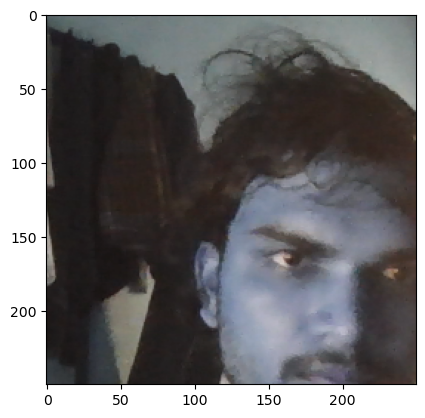

In [14]:
plt.imshow(frame)

# 3. Load and Preprocess Images

# 3.1 Get Image Directories

In [15]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [16]:
ANC_PATH+'\*.jpg'

'data3\\anchor\\*.jpg'

In [17]:
dir_test = anchor.as_numpy_iterator()

In [18]:
print(dir_test.next())

b'data3\\anchor\\82883a01-4ad4-11ee-a73a-98e7437d7afb.jpg'


# 3.2 Preprocessing - Scale and Resize

In [19]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [20]:
img = preprocess('data3\\anchor\\7d7b6fd6-4ad4-11ee-8c91-98e7437d7afb.jpg')

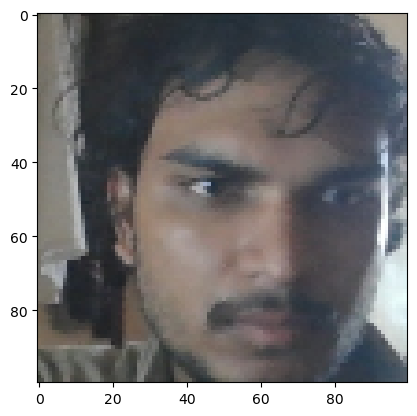

In [21]:
plt.imshow(img)

# 3.3 Create Labelled Dataset

In [22]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives) 

In [23]:
samples = data.as_numpy_iterator()

In [24]:
exampple = samples.next()

In [25]:
exampple

(b'data3\\anchor\\8377ef24-4ad4-11ee-996c-98e7437d7afb.jpg',
 b'data3\\positive\\8e5d3174-4ad4-11ee-8624-98e7437d7afb.jpg',
 1.0)

# 3.4 Build Train and Test Partition

In [26]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_imgimg), preprocess(validation_img), label)

In [27]:
res = preprocess_twin(*exampple)

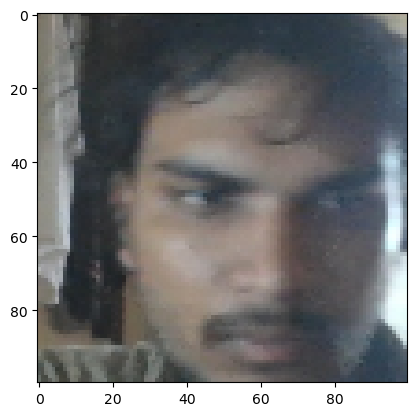

In [28]:
plt.imshow(res[1])

In [29]:
res[2]

1.0

In [30]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [31]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [32]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

# 4.1 Build Embedding Layer

In [33]:
inp = Input(shape=(100,100,3), name='input_image')

In [34]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [35]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [37]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    

In [38]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [39]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [40]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [41]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 17, 128)       26

In [42]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [43]:

embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 17, 17, 128)       26

# 4.2 Build Distance Layer

In [44]:
class L1Dist(Layer):
    def __int__(self,**kwargs):
        super().__int__()
    def call(self,input_embedding,validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [45]:
l1 = L1Dist()

In [47]:
l1(anchor_embedding, validation_embedding)

# 4.3 Make Siamese Model

In [48]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [49]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [50]:
siamese_layer = L1Dist()

In [51]:
distances = siamese_layer(inp_embedding, val_embedding)

In [52]:
classifier = Dense(1, activation='sigmoid')(distances)

In [53]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [54]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [55]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [56]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [57]:
siamese_model = make_siamese_model()

In [58]:
siamese_model.summary()


Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

# 5.1 Setup Loss and Optimizer

In [59]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [60]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

    # 5.2 Establish Checkpoints

In [61]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

    # 5.3 Build Train Step Function

In [62]:
test_batch = train_data.as_numpy_iterator()

In [63]:
batch_1 = test_batch.next()

In [64]:
X = batch_1[:2]

In [65]:
y = batch_1[2]

In [66]:
y

array([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0.],
      dtype=float32)

In [67]:
tf.losses.BinaryCrossentropy??

In [68]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

# 5.4 Build Training Loop

In [69]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

# 5.5 Train the model

In [70]:
EPOCHS = 50

In [71]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
10/10 [==============================] - 283s 26s/step

 Epoch 2/50
10/10 [==============================] - 249s 25s/step

 Epoch 3/50
10/10 [==============================] - 237s 23s/step

 Epoch 4/50
10/10 [==============================] - 239s 24s/step

 Epoch 5/50
10/10 [==============================] - 235s 23s/step

 Epoch 6/50
10/10 [==============================] - 235s 23s/step

 Epoch 7/50
10/10 [==============================] - 234s 23s/step

 Epoch 8/50
10/10 [==============================] - 237s 23s/step

 Epoch 9/50
10/10 [==============================] - 241s 24s/step

 Epoch 10/50
10/10 [==============================] - 240s 24s/step

 Epoch 11/50
10/10 [==============================] - 237s 23s/step

 Epoch 12/50
10/10 [==============================] - 241s 24s/step

 Epoch 13/50
10/10 [======

# 6  Evaluate Model

# 6.1 Import Metrics

In [72]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

    # 6.2 Make Predictions

In [73]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [74]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 2s 2s/step


array([[1.6200206e-08],
       [3.1351366e-09],
       [9.9956757e-01],
       [9.9996471e-01],
       [1.5928683e-07],
       [9.9987227e-01],
       [9.9999887e-01],
       [7.5899981e-10],
       [1.0000000e+00],
       [9.9954718e-01],
       [4.7889705e-07],
       [9.9999982e-01],
       [1.0000000e+00],
       [7.2390839e-07],
       [9.9999398e-01],
       [5.1928431e-08]], dtype=float32)

In [75]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]

In [76]:
y_true

array([0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0.],
      dtype=float32)

    # 6.3 Calculate Metrics 

In [77]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [78]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

# 6.4 Viz Results

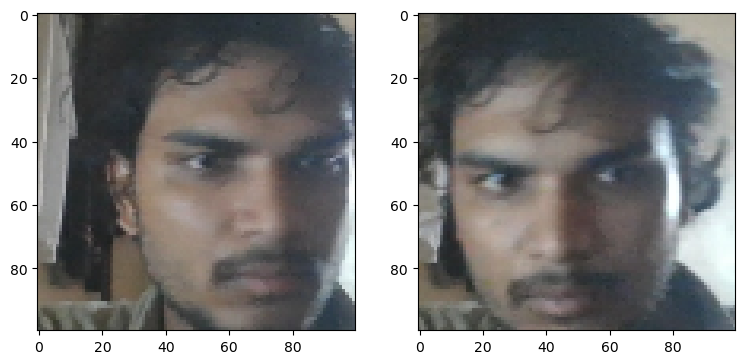

In [79]:
plt.figure(figsize=(9,8))
plt.subplot(1,2,1)
plt.imshow(test_input[8])
plt.subplot(1,2,2)
plt.imshow(test_val[8])
plt.show()

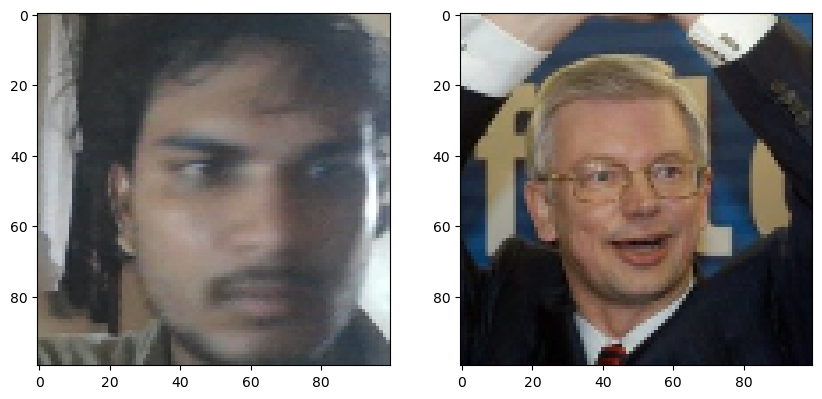

In [80]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [81]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [82]:
L1Dist

__main__.L1Dist

In [83]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [84]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


array([[1.6200206e-08],
       [3.1351366e-09],
       [9.9956757e-01],
       [9.9996471e-01],
       [1.5928683e-07],
       [9.9987227e-01],
       [9.9999887e-01],
       [7.5899981e-10],
       [1.0000000e+00],
       [9.9954718e-01],
       [4.7889705e-07],
       [9.9999982e-01],
       [1.0000000e+00],
       [7.2390839e-07],
       [9.9999398e-01],
       [5.1928431e-08]], dtype=float32)

In [85]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 8. Real Time Test 

# 8.1 Verification Function

In [109]:
application_data\verification_images

SyntaxError: unexpected character after line continuation character (2818603333.py, line 1)

In [86]:
os.listdir(os.path.join('application_data', 'verification_images'))

['8b53dab9-4ad4-11ee-bb13-98e7437d7afb.jpg',
 '8b9cdbb5-4ad4-11ee-b6de-98e7437d7afb.jpg',
 '8bab4f49-4ad4-11ee-8752-98e7437d7afb.jpg',
 '8bbd6806-4ad4-11ee-872c-98e7437d7afb.jpg',
 '8bcc8bfb-4ad4-11ee-b49d-98e7437d7afb.jpg',
 '8bf59093-4ad4-11ee-a0dc-98e7437d7afb.jpg',
 '8c04aa88-4ad4-11ee-8b3e-98e7437d7afb.jpg',
 '8c2d74b1-4ad4-11ee-8578-98e7437d7afb.jpg',
 '8c4e1ad3-4ad4-11ee-878e-98e7437d7afb.jpg',
 '8c5c9c94-4ad4-11ee-bc01-98e7437d7afb.jpg',
 '8c8ee438-4ad4-11ee-8ef4-98e7437d7afb.jpg',
 '8c9dcabe-4ad4-11ee-9cae-98e7437d7afb.jpg',
 '8eb0c5ac-4ad4-11ee-9329-98e7437d7afb.jpg',
 '8ed920c9-4ad4-11ee-a8c0-98e7437d7afb.jpg',
 '8ee83c09-4ad4-11ee-b9c2-98e7437d7afb.jpg',
 '8f04f9f7-4ad4-11ee-a5b4-98e7437d7afb.jpg',
 '8f24c416-4ad4-11ee-abfc-98e7437d7afb.jpg',
 '8f33b148-4ad4-11ee-a719-98e7437d7afb.jpg',
 '8f405279-4ad4-11ee-aae6-98e7437d7afb.jpg',
 '8f4f5a15-4ad4-11ee-b434-98e7437d7afb.jpg',
 '8f56ee23-4ad4-11ee-9b1a-98e7437d7afb.jpg',
 '8f6b5fae-4ad4-11ee-9db0-98e7437d7afb.jpg',
 '8f72cfd7

In [87]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [88]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\8b53dab9-4ad4-11ee-bb13-98e7437d7afb.jpg
application_data\verification_images\8b9cdbb5-4ad4-11ee-b6de-98e7437d7afb.jpg
application_data\verification_images\8bab4f49-4ad4-11ee-8752-98e7437d7afb.jpg
application_data\verification_images\8bbd6806-4ad4-11ee-872c-98e7437d7afb.jpg
application_data\verification_images\8bcc8bfb-4ad4-11ee-b49d-98e7437d7afb.jpg
application_data\verification_images\8bf59093-4ad4-11ee-a0dc-98e7437d7afb.jpg
application_data\verification_images\8c04aa88-4ad4-11ee-8b3e-98e7437d7afb.jpg
application_data\verification_images\8c2d74b1-4ad4-11ee-8578-98e7437d7afb.jpg
application_data\verification_images\8c4e1ad3-4ad4-11ee-878e-98e7437d7afb.jpg
application_data\verification_images\8c5c9c94-4ad4-11ee-bc01-98e7437d7afb.jpg
application_data\verification_images\8c8ee438-4ad4-11ee-8ef4-98e7437d7afb.jpg
application_data\verification_images\8c9dcabe-4ad4-11ee-9cae-98e7437d7afb.jpg
application_data\verification_images\8eb0c5ac-4ad4-11ee-9329-98e

In [89]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

# 8.2 OpenCV Real Time Verification 

In [90]:
import cv2
import os

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    key = cv2.waitKey(10) & 0xFF
    
    if key == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        # Assuming you have a function named 'verify' defined elsewhere
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: application_data\input_image\input_image.jpg : The system cannot find the path specified.
; No such process [Op:ReadFile]

In [ ]:
np.sum(np.squeeze(results) > 0.9)